In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor, print_model_size

In [2]:
# Helper module that sums the output of the main branch and the skip branch.
class Residual(nn.Module):
    def __init__(self, main, skip):
        super().__init__()
        self.main = main
        self.skip = skip

    def forward(self, x):
        return self.main(x) + self.skip(x)

# BasicBlock defined entirely with nn.Sequential
class BasicBlock(nn.Module):
    expansion = 1  # For compatibility with ResNet architectures.

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # Main branch: two 3x3 convolutions with BatchNorm and ReLU (only after the first conv)
        main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # Skip branch: downsample if needed; otherwise, identity.
        if stride != 1 or in_channels != out_channels:
            skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            skip = nn.Identity()
        # Combine the main and skip branches, then apply the final ReLU.
        self.block = nn.Sequential(
            Residual(main, skip),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [3]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Initial convolutional block for CIFAR‑10.
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Layer 1: two BasicBlocks (no downsampling)
            BasicBlock(64, 64, stride=1),
            BasicBlock(64, 64, stride=1),
            # Layer 2: two BasicBlocks, with downsampling on the first block.
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128, stride=1),
            # Layer 3: two BasicBlocks, with downsampling on the first block.
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256, stride=1),
            # Layer 4: two BasicBlocks, with downsampling on the first block.
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512, stride=1),
            # Global average pooling, flattening, and final linear classifier.
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

In [4]:
print_model_size(ResNet())

Total params = 1.117396e+07
Trainable params = 1.117396e+07


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

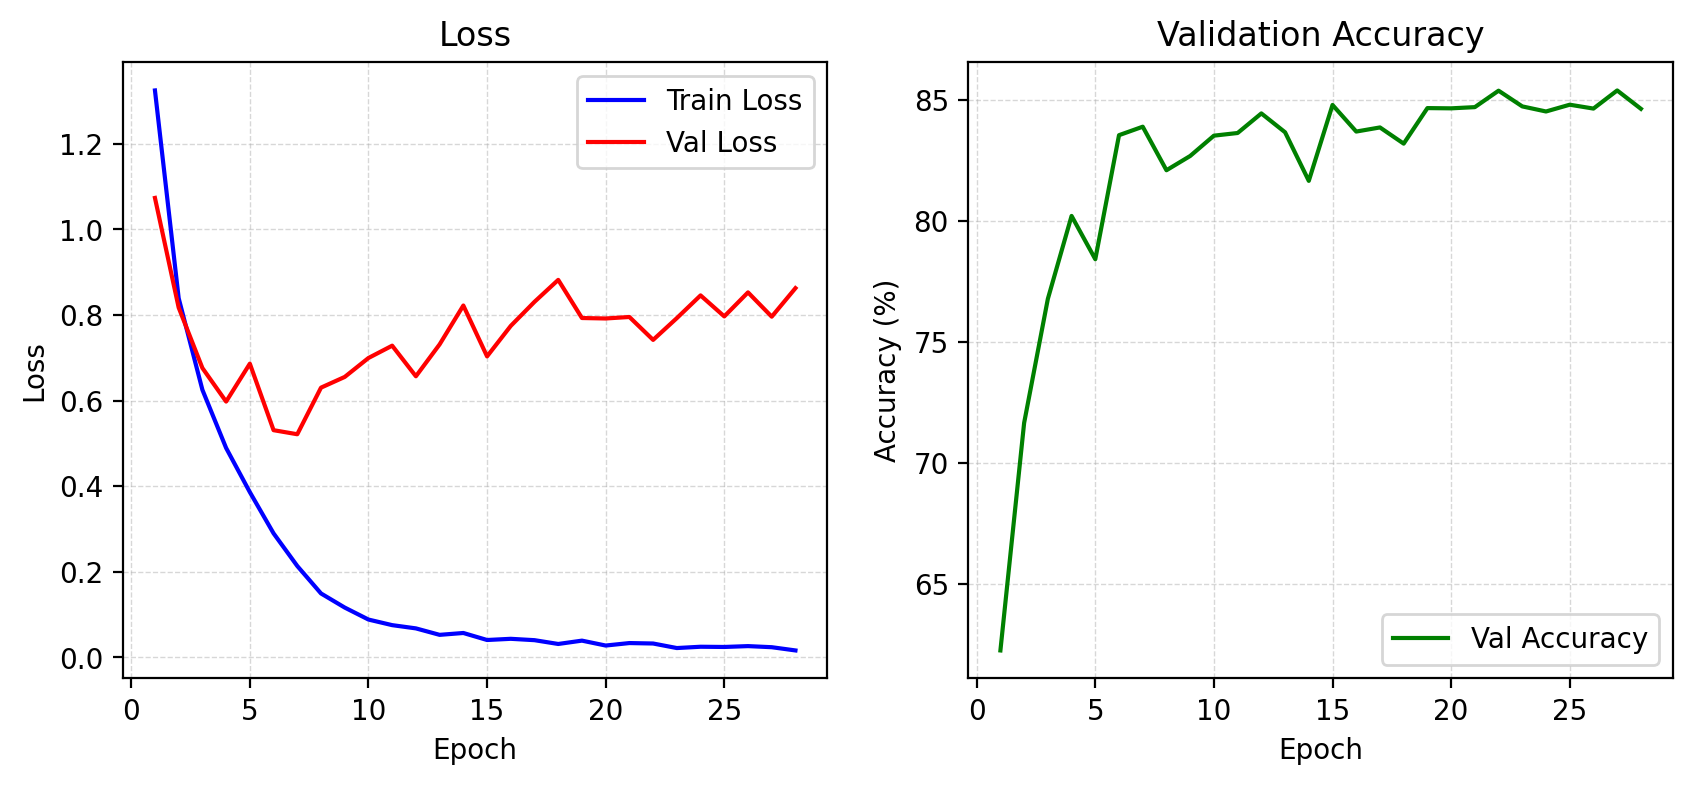

Epoch 28/30:  93%|#########3| 28/30 [11:46<00:52, 26.06s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.3244       |       1.0733       |         62.2400         |
|         2          |       0.8391       |       0.8172       |         71.6500         |
|         3          |       0.6251       |       0.6761       |         76.7800         |
|         4          |       0.4893       |       0.5977       |         80.2100         |
|         5          |       0.3862       |       0.6862       |         78.4200         |
|         6          |       0.2899       |       0.5309       |         83.5500         |
|         7          |       0.2137       |       0.5214       |         83.9000         |
|         8          |       0.1495       |       0.6302       |         82.1000         |
|         9          |       0.1166       |       0.6553       |         82.6900         |

In [5]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)
